In [1]:
#most python scripts start with 'import' statements like this that make
#useful packages available. Examples are 'uproot' which reads in our data
#files and allows them to be read, 'numpy' is a powefule and popular package
#for fast manipultation of arrays and 'scip.stats' is useful for statitical
#analysis, we'll use it to generate and fit fucntions to our data.
import uproot
import uproot_methods.classes.TLorentzVector as LVepm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import cauchy
from scipy.stats import expon
from scipy.stats import norm

from scipy.stats import crystalball
import pandas as pd

In [2]:
#the first thing we want to do is read our data file. The file is hosted on a CERN web-server so you
#will see a full web address. As this file is large and we are reading over the web,
#this step can take a few minutes
#%timeit eventsData = uproot.open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/Data/data_D.2lep.root")["mini"]

eventsData = uproot.open("data_Skim_mumu.root")["mini"] #this command tells uproot where to find the file
df = eventsData.pandas.df(["muon_E", "muon_pt", "muon_phi", "muon_eta", "muon_charge", "muon_etcone20", "muon_ptcone30"])

print("File has been successfully opened!")

File has been successfully opened!


In [3]:
#the file is now represented by the variable "eventsData".
#we can have a peek inside the file to see what kind of information is available
#by running the following command

eventsData.show()

muon_pt                    (no streamer)              asdtype("('>f4', (2,))")
muon_eta                   (no streamer)              asdtype("('>f4', (2,))")
muon_phi                   (no streamer)              asdtype("('>f4', (2,))")
muon_E                     (no streamer)              asdtype("('>f4', (2,))")
muon_charge                (no streamer)              asdtype("('>i4', (2,))")
muon_etcone20              (no streamer)              asdtype("('>f8', (2,))")
muon_ptcone30              (no streamer)              asdtype("('>f8', (2,))")


In [4]:
nEvents = 200000 
#this is the total number of collisions/events we want to access from the file, you can reduce this
#for quick test, for final results 100000 events should be enough

muon_E, muon_pt, muon_phi, muon_eta, muon_etcone20, muon_ptcone30 = eventsData.arrays(["muon_E", "muon_pt", "muon_phi", "muon_eta", "muon_etcone20",  "muon_ptcone30"], outputtype=tuple, entrystop=nEvents)
flatData = LVepm.TLorentzVectorArray.from_ptetaphi(muon_pt, muon_eta, muon_phi, muon_E)

In [5]:
#cut0: we require the charges of the muons to be opposite (by requiring the sum to be 0)
cuts0 = df[ ((df["muon_charge[0]"]) + (df["muon_charge[1]"])  == 0)   ]

#cut1: we require the transervse momentum of each muon to be above 20000 MeV'
cuts1 = cuts0[(cuts0["muon_pt[0]"] > 20000) & (cuts0["muon_pt[1]"] > 20000 )]

#cut2: we require the absolute pseudorapidity of each muon to be below 2.4'
cuts2 = cuts1[( np.abs(cuts1["muon_eta[0]"]) < 2.4) & ( np.abs(cuts1["muon_eta[1]"]) < 2.4)]

# cuts 2&3: we require the muons to be isolated from other particles in the event these criteria will be
# explored later in step 7, for now leave them commented out.

cuts3 = cuts2[( (cuts2["muon_etcone20[0]"])/(cuts2["muon_pt[0]"]) < 0.1) & ( (cuts2["muon_etcone20[1]"])/(cuts2["muon_pt[1]"]) < 0.1) ]
cuts4 = cuts3[( (cuts3["muon_ptcone30[0]"])/(cuts3["muon_pt[0]"]) < 0.1) & ( (cuts3["muon_ptcone30[1]"])/(cuts3["muon_pt[1]"]) < 0.1) ]

#we copy out finally selected dataframe to a new variable 'finalData' for convenience
finalData =  cuts4 # you will have to change this line when you want to inlcude the muon 
#isolation criteria, i.e., "finalData =  cuts4" 

#let's check how many events we have selected after all our criteria have been applied
print("Number of selected events = " + str(len(finalData.index)))

# and have a look at our finally selected dataframe
finalData

Number of selected events = 522476


,muon_E[0],muon_E[1],muon_pt[0],muon_pt[1],muon_phi[0],muon_phi[1],muon_eta[0],muon_eta[1],muon_charge[0],muon_charge[1],muon_etcone20[0],muon_etcone20[1],muon_ptcone30[0],muon_ptcone30[1]
entry,,,,,,,,,,,,,,
0,59232.882812,55261.050781,49085.519531,39126.156250,0.147713,-2.867906,0.632411,0.879536,1,-1,-991.511536,603.206848,0.000000,0.000000
1,127074.187500,33773.015625,65642.484375,33766.769531,-1.462382,-2.781488,1.279104,-0.018981,-1,1,-788.608521,-1062.793091,1063.258789,0.000000
2,201868.750000,54080.953125,38357.257812,32836.464844,-2.771525,0.050257,-2.344670,-1.083706,-1,1,-320.122009,670.660217,0.000000,0.000000
3,79745.382812,28305.017578,69548.132812,27166.605469,1.549823,-0.946571,-0.535110,0.288473,-1,1,39.919617,-149.053040,0.000000,0.000000
4,28867.724609,98152.656250,27808.724609,25207.083984,-1.008342,1.501000,0.275083,-2.035634,-1,1,121.450531,1119.237671,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549252,37704.515625,53827.457031,33141.777344,31681.882812,2.159711,-1.051486,-0.518885,1.122499,-1,1,-380.786377,2450.864258,0.000000,1780.051636
549253,38264.097656,99136.992188,36691.769531,30524.439453,2.490635,-0.590939,0.291705,1.846531,-1,1,188.411438,-137.441544,0.000000,0.000000
549254,39036.566406,114896.968750,36656.058594,28371.234375,0.891378,-2.345073,0.358460,2.076203,-1,1,-491.892853,-164.486343,0.000000,0.000000


In [6]:
#first we make arrays of four-vectors for the muons. we make separate arrays for muon[0] (leading) and muon[1] (sub-leading)
lvArray0 = LVepm.TLorentzVectorArray.from_ptetaphi(finalData["muon_pt[0]"], finalData["muon_eta[0]"], finalData["muon_phi[0]"],finalData["muon_E[0]"])
lvArray1 = LVepm.TLorentzVectorArray.from_ptetaphi(finalData["muon_pt[1]"], finalData["muon_eta[1]"], finalData["muon_phi[1]"],finalData["muon_E[1]"])

# the TLorentzVectorArray class conveniently allows us to simply add the array
# to get an array of four-vectors representing the dimuon system in each event
lvArray = lvArray0 + lvArray1
lvArray

<TLorentzVectorArray [TLorentzVector(x=10881, y=-3350.9, z=72178, t=1.1449e+05) TLorentzVector(x=-24498, y=-77156, z=1.0817e+05, t=1.6085e+05) TLorentzVector(x=-2965.6, y=-12223, z=-2.4116e+05, t=2.5595e+05) ... TLorentzVector(x=3195.4, y=8232.8, z=1.2476e+05, t=1.5393e+05) TLorentzVector(x=-1304.6, y=-3035.3, z=-42814, t=1.0089e+05) TLorentzVector(x=-20695, y=822.45, z=-29639, t=96379)] at 0x7fbb492f88b0>

In [7]:
#we set up a few parmaters for our histogram, min and max of the x-axis (mass)
minMass = 71000
maxMass = 110000

#the number of bins
nBins = 250 

# creating the histogram as two arrays (bin edges & counts in the bins) numpy
countsData, edges = np.histogram(lvArray.mass, bins=nBins, range=(minMass, maxMass))

# get the width of each bin
bin_width = edges[1] - edges[0]
# sum over number in each bin and mult. by bin width, which can be factored out.
# This gives us the integral
integral = bin_width * sum(countsData[0:nBins])

# we can make an array of the centre of each bin directly from the edges array this will be useful in plotting our pdf
centres = (edges[1:] + edges[:-1]) / 2

#fit a Cauchy distributions to the dimuon mass data
#mu, std = cauchy.fit(lvArray.mass)
#print("mu = " + str(mu))
#print("std = " + str(std))

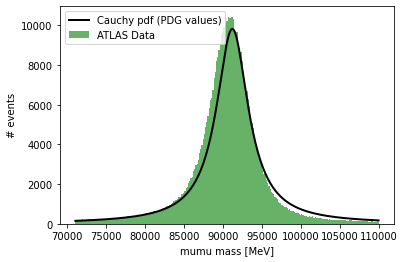

In [8]:
mZPDG  = 91187.6
sigmaZPDG = 2495.2

#let's make the comparison plot
plt.figure()
p = (cauchy.pdf(centres, mZPDG, sigmaZPDG) * integral)
plt.plot(centres, p, 'k',label="Cauchy pdf (PDG values)", linewidth=2)
plt.hist(lvArray.mass, bins=nBins, range=[minMass, maxMass],label="ATLAS Data", alpha=0.6, color='g')
plt.legend()
plt.xlabel("mumu mass [MeV]")
plt.ylabel("# events")
plt.show()

In [9]:
#chi-squared function
def calcChiSq(obs, preds):
    chiSq = 0.0
    ndf = len(obs)
    for bin in range(0, len(obs)):
        diff = preds[bin] - obs[bin]
        #print("diff = " + str(diff))
        var = ( np.abs(preds[bin])) 
        if (var != 0):
            chiSq += (diff**2)/(var)
            #print("obs, pred, diff, var  chi contrib = "+  str( obs[bin]) +" " +  str(preds[bin]) +" "+  str(diff) +" "+  str(var) +" " + str((diff**2)/(var)))
    return chiSq, ndf

90754


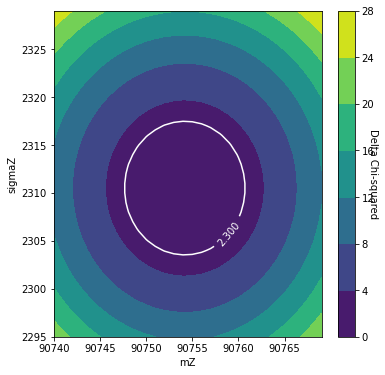

best-fit = 90754


In [10]:
#How about fitting the mass and the width at the same time?
minMz = 90740
maxMz = 90770

minSigmaZ = 2295
maxSigmaZ = 2330
step = 1

mZAr = np.arange(minMz, maxMz, step)
sigmaZAr = np.arange(minSigmaZ, maxSigmaZ, step)
chi2Ar = np.empty( (len(sigmaZAr), len(mZAr) ))

X, Y = np.meshgrid(mZAr, sigmaZAr)


bestFitMz2D = 0.0
minChi2 = 1000000

for yi in range(0, len(sigmaZAr)):
    for xi in range(0, len(mZAr)):
        #print( str(X[xi,yi]) + "," + str(Y[xi,yi]) )
        #print(chi2AtPoint(X[xi,yi],Y[xi,yi]))
        countsPDF = (cauchy.pdf(centres, X[yi, xi],Y[yi, xi]) * integral)
        chi2, ndf = calcChiSq(countsData, countsPDF)
        chi2Ar[yi, xi] = chi2
        if(chi2 < minChi2):
            #print("chi2 = " + str(chi2) + " mz = " + str(X[yi, xi]))
            minChi2 = chi2
            bestFitMz2D = X[yi, xi]

print(bestFitMz2D)
minChi2 = np.min(chi2Ar)
deltaChi2Ar = chi2Ar - minChi2


#plot 
levels = [2.3] # 'statitical uncertainty' on our mZ,sigmaZ measurement corresponds 
#to the contour corresponding to delta-chi^2 = 2.3 on the 2-D chi-squared 'surface'
# This allows the contour to be drawn so we can 'see' the uncertainty. 

fig = plt.figure(figsize=(6,6))
ax = fig.gca()

cset = plt.contour(mZAr,sigmaZAr,deltaChi2Ar, levels=levels, colors=['white'])
cfset = plt.contourf(mZAr,sigmaZAr,deltaChi2Ar,  cmap='coolwarm')

h = plt.contourf(mZAr,sigmaZAr,deltaChi2Ar)

cbar = plt.colorbar(h)
cbar.set_label('Delta Chi-squared', rotation=270)
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('mZ')
ax.set_ylabel('sigmaZ')
plt.show()

#extract 2D result and uncertainty
my2DResult = bestFitMz2D
print("best-fit = " + str(my2DResult))

# The delta-chi^2 = 2.3 contour is visible and represents the 2-D 68% confidence interval on mZ and sigmaZ.

# How should we quote uncertainty on mZ for this 2-D fit?

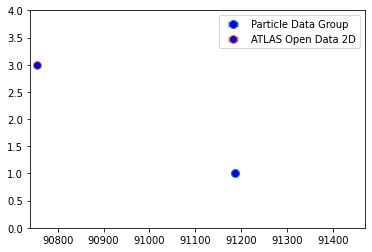

In [11]:
#compare to PDG world average
mZPDG =  91187.6
sigmaZPDG = 2.1

mZPDGAr = np.array([mZPDG]) 
sigZPDGAr = np.array([sigmaZPDG]) 
yPDGAr = np.array([1.0]) 


mZ2D = np.array([my2DResult]) 
y2D = np.array([3.0]) 

plt.figure()

ax = plt.gca()
ax.set_xlim(minMz, maxMz+700)#need to extend x axis range to include PDG value
ax.set_ylim(0.0, 4.0)

plt.errorbar(mZPDGAr, yPDGAr, xerr=sigZPDGAr, label="Particle Data Group", elinewidth=5,  fmt="o", mfc="blue", ms=8)
plt.errorbar(mZ2D, y2D, xerr=0, fmt="o", label="ATLAS Open Data 2D", elinewidth=5, ms=8, mfc='blue')

plt.legend()
plt.show()